In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression

In [2]:
df_cur = pd.read_csv('data/cust.csv')
df_cur['BE_SEGMENT'] = df_cur['BE_SEGMENT'].str[0].fillna(-1).astype('int')
df_prev = pd.read_csv('data/cust_prev.csv')

df_comb = df_prev.merge(df_cur, on='id', suffixes=['_prev', '_cur'], how='outer')
df_comb = df_comb[df_comb['BE_SEGMENT_prev'] != -1]
df_comb['be_segment_p1m'] = df_comb['BE_SEGMENT_cur']

df_comb['is_affluent_prev'] = (df_comb['BE_SEGMENT_prev'] <= 2).astype(int)
df_comb['is_affluent_cur'] = (df_comb['BE_SEGMENT_cur'] <= 2).astype(int)
df_comb = df_comb[df_comb['is_affluent_prev'] == 0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_reg = df_comb[['id', 'is_affluent_cur']]
df_reg = df_reg.drop_duplicates('id')

train = pd.read_csv('data/model/train.csv')[['id', 't1']].rename({'t1': 'is_affluent_cur'}, axis=1)
val = pd.read_csv('data/model/validate.csv')[['id', 't1']].rename({'t1': 'is_affluent_cur'}, axis=1)
test = pd.read_csv('data/model/test.csv')[['id', 't1']].rename({'t1': 'is_affluent_cur'}, axis=1)

train_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in train['id']]
val_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in val['id']]
test_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in test['id']]

In [4]:
del df_comb

# Transactions 

In [5]:
fname = 'data/currentacct_txn.csv'
col_date = 'D_TRANSACTION_DATE'
col_amt = 'D_TRAN_AMOUNT'
col_mult = 'D_TRAN_TYPE'

In [6]:
df_saving = pd.read_csv(fname)
# df_saving = df_saving[~df_saving['PRODUCT_TYPE'].isna()]

tmp = set(df_reg['id'])
df_saving = df_saving[[cid in tmp for cid in df_saving['id']]]

df_saving['day'] = pd.to_datetime(df_saving[col_date])

df_saving['transact_d'] = df_saving['transact_c'] = df_saving[col_amt]
df_saving.loc[df_saving[col_mult] == 'C', 'transact_d'] = 0
df_saving.loc[df_saving[col_mult] == 'D', 'transact_c'] = 0
df_saving = df_saving[['id', 'day', 'transact_c', 'transact_d']]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
placeholders = []
for cid in df_reg['id']:
    tmp = pd.date_range(start='1/1/2021', end='31/12/2021')
    tmp = pd.DataFrame({'day': tmp, 'transact_c': 0, 'transact_d': 0})
    tmp.insert(0, 'id', cid)
    placeholders.append(tmp)
df_saving = df_saving.append(pd.concat(placeholders))

df_saving['day'] = (pd.to_datetime(df_saving['day']) \
                       .apply(lambda x: x.value) - pd.to_datetime('1/1/2021').value) // 86400000000000

df_saving = df_saving.sort_values(['id', 'day'])
df_saving = df_saving.groupby(['id', 'day']).sum().reset_index(drop=False)

### Feature extraction

In [8]:
rolling_window = 21

dict_rolled = {}
for cid in tqdm(df_reg['id']):
    df = df_saving[df_saving['id'] == cid][['transact_c', 'transact_d']]
    df = df.rolling(window=rolling_window).apply(lambda x : sum(x) / rolling_window)
    df = df.dropna()
    dict_rolled[cid] = df

  0%|          | 0/5994 [00:00<?, ?it/s]

(-7.649692623711514,
 11.641895637695738,
 -7.649692623711514,
 11.641914268140361)

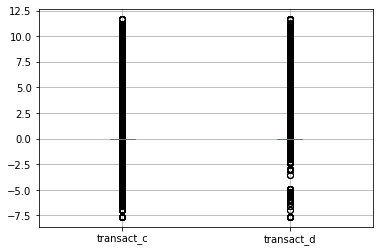

In [9]:
tmp = pd.concat(list(dict_rolled.values()))
tmp = np.log(tmp.replace({0: 1}))
tmp.boxplot()
tmp['transact_c'].min(), tmp['transact_c'].max(), tmp['transact_d'].min(), tmp['transact_d'].max()

In [10]:
bin_size = 0.1
bin_min, bin_max = -7.9, 11.5
bins = [bin_min + i * bin_size for i in range(int((bin_max - bin_min) / bin_size) + 1)]

def transacts_to_bins(transacts):
    transacts = np.log(transacts.replace({0: 1}))
    feat = np.zeros((len(bins)))
    tmp = np.digitize(transacts, bins) - 1
    tmp = pd.DataFrame(tmp).reset_index(drop=False).groupby(0).count()['index']
    feat[tmp.index] = tmp
    return feat

X = np.zeros((len(df_reg), len(bins) * 2))
for i, cid in tqdm(enumerate(df_reg['id'])):
    feat_c = transacts_to_bins(dict_rolled[cid]['transact_c'])
    feat_d = transacts_to_bins(dict_rolled[cid]['transact_d'])
    X[i, :] = np.concatenate([feat_c, feat_d])

0it [00:00, ?it/s]

In [11]:
X.sum(axis=0)

array([0.000000e+00, 0.000000e+00, 8.940000e+02, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 4.210000e+02, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 4.540000e+02, 0.000000e+00, 0.000000e+00,
       9.190000e+02, 0.000000e+00, 1.180000e+03, 0.000000e+00,
       9.050000e+02, 5.630000e+02, 0.000000e+00, 6.420000e+02,
       4.540000e+02, 2.760000e+02, 2.640000e+02, 3.230000e+02,
       5.500000e+02, 1.070000e+02, 3.150000e+02, 4.190000e+02,
       3.170000e+02, 1.970000e+02, 2.430000e+02, 4.010000e+02,
       4.220000e+02, 2.230000e+02, 3.990000e+02, 5.070000e+02,
       5.000000e+02, 4.410000e+02, 5.470000e+02, 2.610000e+02,
       4.490000e+02, 2.250000e+02, 2.780000e+02, 1.750000e+02,
       1.540000e+02, 3.160000e+02, 2.550000e+02, 1.480000e+02,
       1.650000e+02, 3.750000e+02, 1.830000e+02, 2.610000e+02,
       3.940000e+02, 3.690000e+02, 3.810000e+02, 4.390000e+02,
       3.510000e+02, 4.410000e+02, 4.650000e+02, 5.5600

### Modelling (SVM)

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    confusion_matrix, roc_curve, 
    precision_recall_fscore_support, plot_roc_curve, roc_auc_score
)

y = df_reg['is_affluent_cur']

X_train = X[train_idxs, :]
y_train = np.array(y)[train_idxs]
X_val = X[val_idxs, :]
y_val = np.array(y)[val_idxs]
X_test = X[test_idxs, :]
y_test = np.array(y)[test_idxs]

In [13]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
svm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

In [14]:
pred_probs = svm.predict_proba(X_val)

In [15]:
pred = (pred_probs[:, 0] < 0.955).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(y_val, pred, average='weighted')
print(precision, recall, f1)
confusion_matrix(pred, y_val)

0.9329844006568143 0.8611111111111112 0.8923587279798672


array([[760,  24],
       [101,  15]])

0.6434974239852288

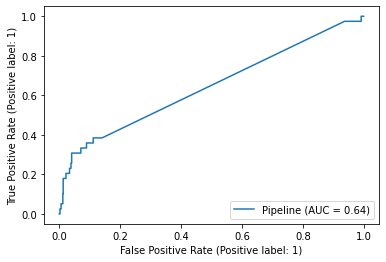

In [16]:
plot_roc_curve(svm, X_val, y_val)
roc_auc_score(y_val, pred_probs[:, 1])

Hyperparameters and result:
```
rolling_window = 21
bin_size = 0.1
bin_min, bin_max = -7.9, 11.5
auc = 0.64/0.65
```